In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Task 1: Import data into Python environment.

In [2]:
comcast_data = pd.read_csv("Dataset/Comcast_telecom_complaints_data.csv")

In [3]:
comcast_data.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No


In [4]:
comcast_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Ticket #                     2224 non-null   object
 1   Customer Complaint           2224 non-null   object
 2   Date                         2224 non-null   object
 3   Date_month_year              2224 non-null   object
 4   Time                         2224 non-null   object
 5   Received Via                 2224 non-null   object
 6   City                         2224 non-null   object
 7   State                        2224 non-null   object
 8   Zip code                     2224 non-null   int64 
 9   Status                       2224 non-null   object
 10  Filing on Behalf of Someone  2224 non-null   object
dtypes: int64(1), object(10)
memory usage: 191.2+ KB


In [5]:
comcast_data.duplicated().sum()

0

#### Task 1.1: Exploring the Dataset

In [6]:
comcast_data.columns

Index(['Ticket #', 'Customer Complaint', 'Date', 'Date_month_year', 'Time',
       'Received Via', 'City', 'State', 'Zip code', 'Status',
       'Filing on Behalf of Someone'],
      dtype='object')

In [7]:
comcast_data['Received Via'].unique()

array(['Customer Care Call', 'Internet'], dtype=object)

In [8]:
comcast_data['Received Via'].value_counts()

Customer Care Call    1119
Internet              1105
Name: Received Via, dtype: int64

In [9]:
top_15_city_max_complains = comcast_data['City'].value_counts()[:15]
top_15_city_min_complains = comcast_data['City'].value_counts(ascending = True)[:15]

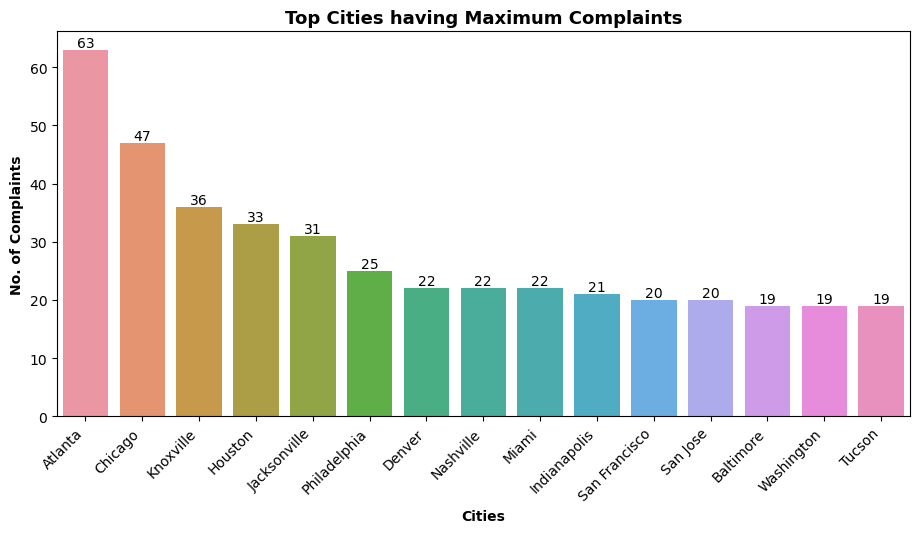

In [10]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_city_max_complains.index, y = top_15_city_max_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top Cities having Maximum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('Cities', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

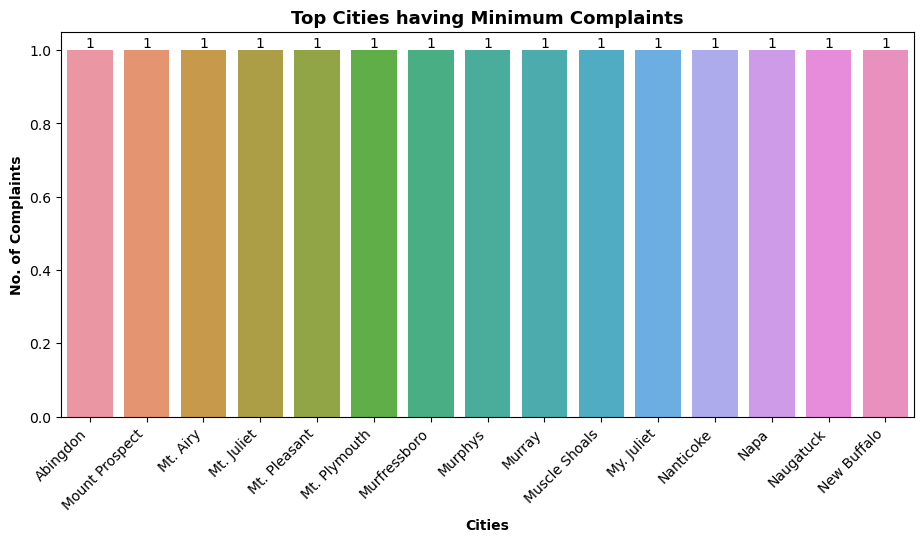

In [11]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_city_min_complains.index, y = top_15_city_min_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top Cities having Minimum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('Cities', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

In [12]:
top_15_state_max_complains = comcast_data['State'].value_counts()[:15]
top_15_state_min_complains = comcast_data['State'].value_counts(ascending = True)[:15]

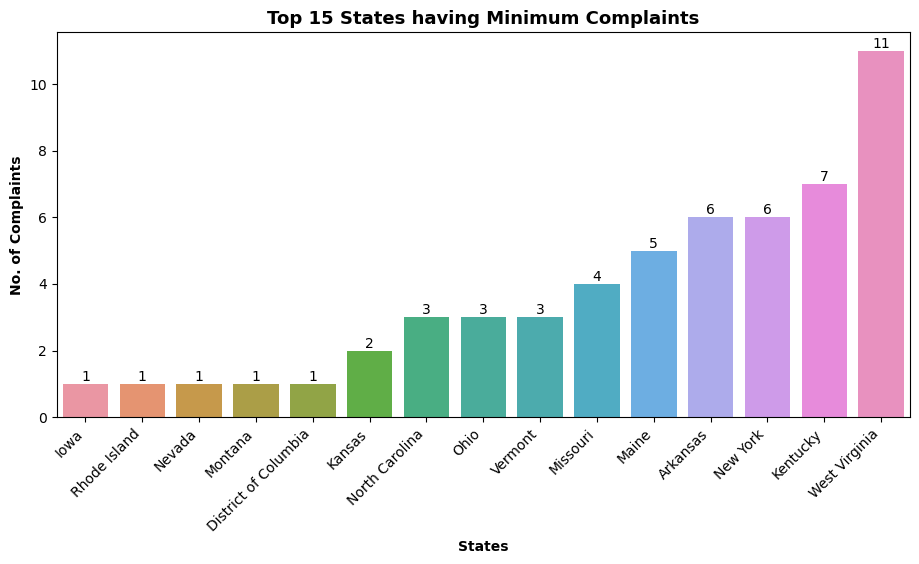

In [13]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_state_min_complains.index, y = top_15_state_min_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 States having Minimum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('States', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

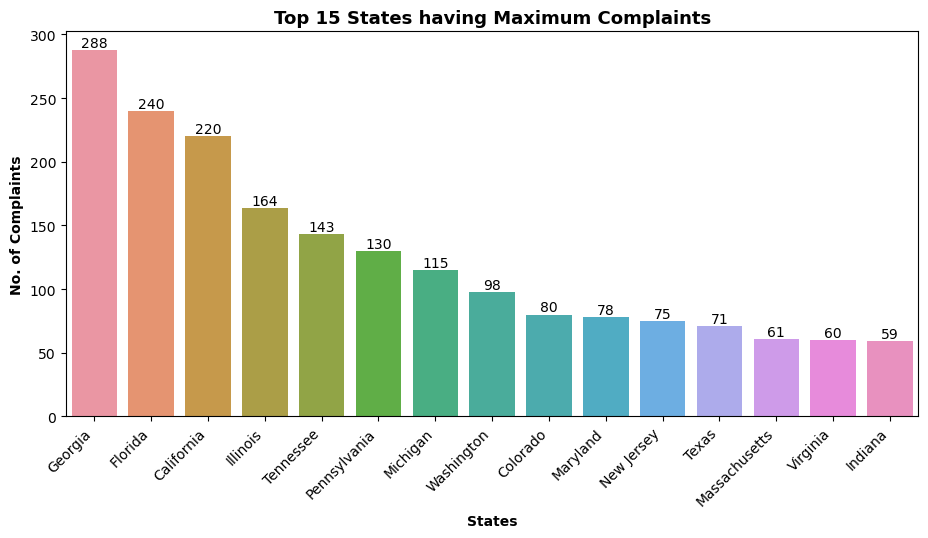

In [14]:
plt.figure(figsize=(11,5))
ax = sns.barplot(x = top_15_state_max_complains.index, y = top_15_state_max_complains.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 States having Maximum Complaints', fontsize = 13, fontweight="bold")
plt.xlabel('States', fontweight="bold")
plt.ylabel('No. of Complaints', fontweight="bold");

In [15]:
comcast_data['Zip code'].nunique()

1543

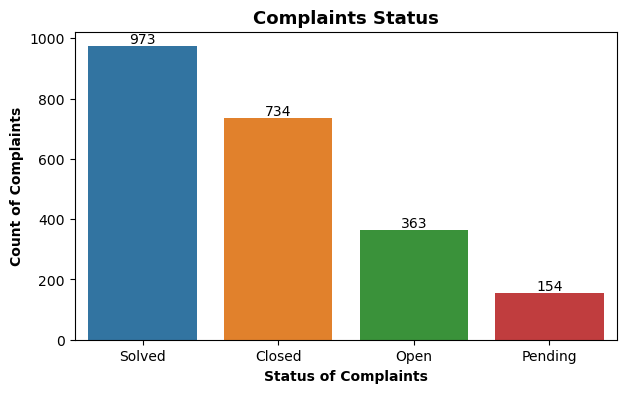

In [16]:
plt.figure(figsize=(7,4))
ax = sns.barplot(x = comcast_data['Status'].value_counts().index, y = comcast_data['Status'].value_counts().values)
ax.bar_label(ax.containers[0])
plt.title('Complaints Status', fontsize = 13, fontweight="bold")
plt.xlabel('Status of Complaints', fontweight="bold")
plt.ylabel('Count of Complaints', fontweight="bold");

In [17]:
compaint_received_by = comcast_data['Filing on Behalf of Someone'].value_counts()
compaint_received_by

No     2021
Yes     203
Name: Filing on Behalf of Someone, dtype: int64

In [18]:
compaint_received_by.index = ['Self', 'Filed on someone\'s behalf']
compaint_received_by

Self                         2021
Filed on someone's behalf     203
Name: Filing on Behalf of Someone, dtype: int64

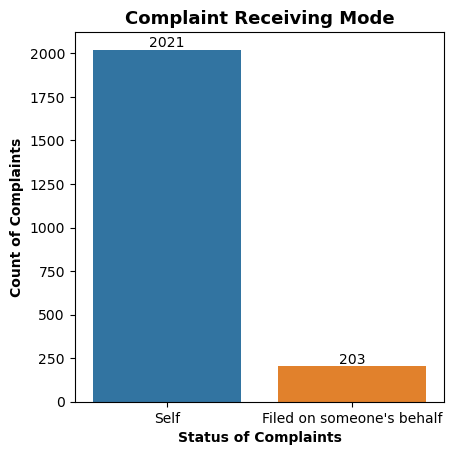

In [19]:
ax = sns.barplot(x = compaint_received_by.index, y = compaint_received_by.values)
ax.set_box_aspect(2/len(ax.patches)) #change 10 to modify the y/x axis ratio
ax.bar_label(ax.containers[0])
plt.title('Complaint Receiving Mode', fontsize = 13, fontweight="bold")
plt.xlabel('Status of Complaints', fontweight="bold")
plt.ylabel('Count of Complaints', fontweight="bold");

### Task 2: Provide the trend chart for the number of complaints at monthly and daily granularity levels.

In [20]:
comcast_data.head(3)

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes


In [21]:
comcast_data.columns

Index(['Ticket #', 'Customer Complaint', 'Date', 'Date_month_year', 'Time',
       'Received Via', 'City', 'State', 'Zip code', 'Status',
       'Filing on Behalf of Someone'],
      dtype='object')

In [22]:
comcast_data = comcast_data.drop(['Ticket #', 'Date', 'Zip code'], axis = 1)

In [23]:
comcast_data['Date_month_year'] = pd.to_datetime(comcast_data['Date_month_year'])

In [24]:
comcast_data.head(3)

,Customer Complaint,Date_month_year,Time,Received Via,City,State,Status,Filing on Behalf of Someone
0,Comcast Cable Internet Speeds,2015-04-22,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No
1,Payment disappear - service got disconnected,2015-08-04,10:22:56 AM,Internet,Acworth,Georgia,Closed,No
2,Speed and Service,2015-04-18,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes


In [25]:
comcast_data['Day'] = comcast_data['Date_month_year'].dt.day
comcast_data['Month'] = comcast_data['Date_month_year'].dt.month_name()
comcast_data['Month_num'] = comcast_data['Date_month_year'].dt.month
comcast_data['Year'] = comcast_data['Date_month_year'].dt.year
comcast_data['Quarter'] = comcast_data['Date_month_year'].dt.quarter

In [26]:
comcast_data = comcast_data.drop(['Date_month_year'], axis = 1)

In [27]:
comcast_data.head(3)

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2


In [28]:
day_wise_tickets_count = comcast_data.groupby(['Day']).count()['Customer Complaint']
day_wise_tickets_count.head()

Day
4     206
5     131
6     272
13     68
14     54
Name: Customer Complaint, dtype: int64

#### Trend Chart at Daily Granularity Level

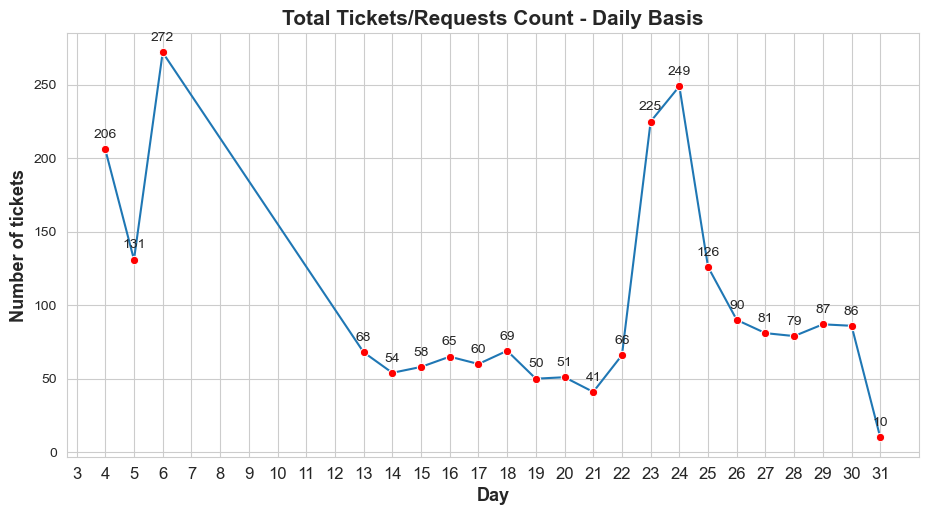

In [29]:
plt.figure(figsize=(11,5.5))
sns.set_style("whitegrid")

ax = sns.lineplot(x = day_wise_tickets_count.index, y = day_wise_tickets_count.values, marker='o', mfc = 'red')

for xval,yval in zip(day_wise_tickets_count.index, day_wise_tickets_count.values):
    ax.annotate(f'{yval}', 
                xy=(xval,yval),
                xytext=(0, 6),
                textcoords='offset points',
               ha='center', va='bottom')
    
plt.xticks(ticks=range(3, 32, 1), fontsize=12)
plt.title('Total Tickets/Requests Count - Daily Basis', fontsize=15, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('Day', fontsize=13, fontweight="bold");

In [30]:
month_wise_tickets_count = comcast_data.groupby(['Month_num', 'Month']).count()['Customer Complaint']
month_wise_tickets_count = month_wise_tickets_count.reset_index(level = 0, drop = True)
month_wise_tickets_count.head()

Month
January      55
February     59
March        45
April       375
May         317
Name: Customer Complaint, dtype: int64

#### Trend Chart at Monthly Granularity Level

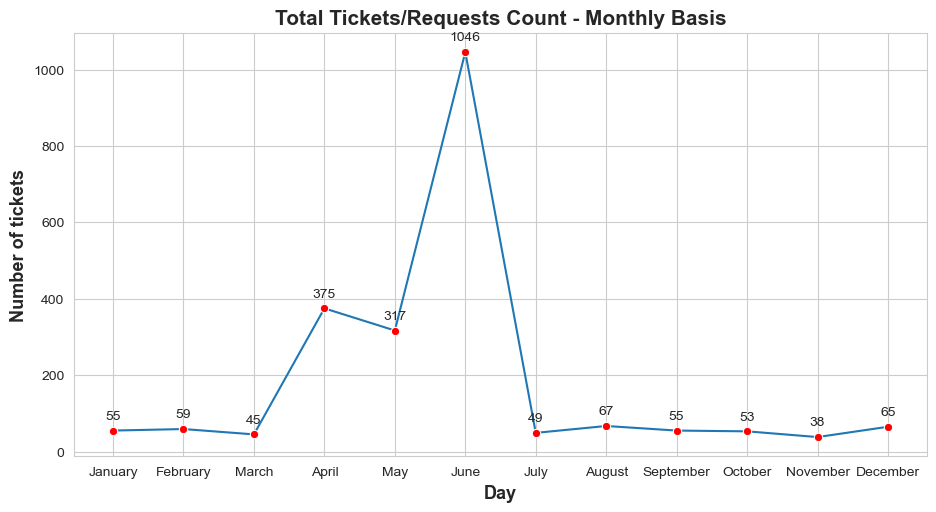

In [31]:
plt.figure(figsize=(11,5.5))
sns.set_style("whitegrid")

ax = sns.lineplot(x = month_wise_tickets_count.index, y = month_wise_tickets_count.values, marker='o', mfc = 'red')

for xval,yval in zip(month_wise_tickets_count.index, month_wise_tickets_count.values):
    ax.annotate(f'{yval}', 
                xy=(xval,yval),
                xytext=(0, 6),
                textcoords='offset points',
               ha='center', va='bottom')
    
plt.title('Total Tickets/Requests Count - Monthly Basis', fontsize=15, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('Day', fontsize=13, fontweight="bold");

### Task 3: Provide a table with the frequency of complaint types.

In [ ]:
def preprocess(sentence):
    
    sentence = sentence.lower()
    sentence = sentence.replace('.', '')
    sentence = sentence.replace('[', '')
    sentence = sentence.replace(']', '')
    
    tokens = [token.text for token in nlp(sentence) if not (token.is_stop or token.like_num or token.is_punct or token.is_space)]
    
    tokens = ' '.join(tokens)
    return tokens

In [ ]:
from wordcloud import WordCloud
wc = WordCloud()
wc = wc.generate(article.cleaned_text)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off');

### Task 4: Create a new categorical variable with value as Open and Closed. 

- Open & Pending is to be categorized as **Open** and Closed & Solved is to be categorized as **Closed**.

In [32]:
comcast_data.head(3)

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2


In [33]:
def assign_ticket_state(ticket_status):
    ticket_status = str(ticket_status).strip().lower()
    if (ticket_status == 'open') | (ticket_status == 'pending'):
        return 'Open'
    elif (ticket_status == 'closed') | (ticket_status == 'solved'):
        return 'Closed'
    else:
        return 'Undefined'

In [34]:
comcast_data['Ticket_State'] = comcast_data['Status'].apply(lambda x: assign_ticket_state(x))

In [35]:
comcast_data.head(3)

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter,Ticket_State
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2,Closed
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3,Closed
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2,Closed


In [36]:
comcast_data['Ticket_State'].value_counts()

Closed    1707
Open       517
Name: Ticket_State, dtype: int64

In [37]:
ticket_state_percent = ((comcast_data['Ticket_State'].value_counts()/comcast_data.shape[0])*100).round(2)
ticket_state_percent

Closed    76.75
Open      23.25
Name: Ticket_State, dtype: float64

In [38]:
[0.04]*len(ticket_state_percent)

[0.04, 0.04]

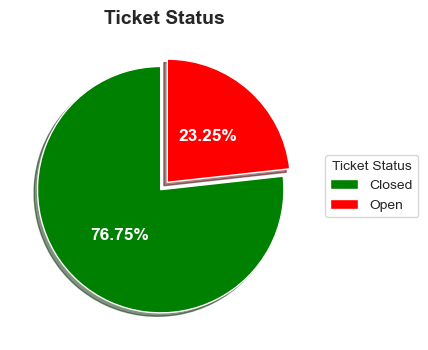

In [155]:
fig, ax = plt.subplots(figsize=[12,4])
labels = ticket_state_percent.index
wedges, texts, autopcts = ax.pie(x= ticket_state_percent, 
                        autopct="%1.2f%%",
                        explode=[0.04]*len(ticket_state_percent), 
                        #labels=labels, 
                        pctdistance=0.5,
                        shadow=True,
                        colors = ['Green', 'Red'],
                        startangle = 90)
# Adding legend
ax.legend(wedges, ['Closed', 'Open'],
          title ="Ticket Status",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.title("Ticket Status", fontsize=14, fontweight="bold");

### Task 5: Provide state wise status of complaints in a stacked bar chart. Use the categorized variable from Q3. 

Provide insights on:
- Which state has the maximum complaints
- Which state has the highest percentage of unresolved complaints

In [40]:
comcast_data.columns

Index(['Customer Complaint', 'Time', 'Received Via', 'City', 'State', 'Status',
       'Filing on Behalf of Someone', 'Day', 'Month', 'Month_num', 'Year',
       'Quarter', 'Ticket_State'],
      dtype='object')

In [41]:
comcast_data[['Customer Complaint', 'State', 'Quarter', 'Status', 'Ticket_State']].head()

,Customer Complaint,State,Quarter,Status,Ticket_State
0,Comcast Cable Internet Speeds,Maryland,2,Closed,Closed
1,Payment disappear - service got disconnected,Georgia,3,Closed,Closed
2,Speed and Service,Georgia,2,Closed,Closed
3,Comcast Imposed a New Usage Cap of 300GB that ...,Georgia,3,Open,Open
4,Comcast not working and no service to boot,Georgia,2,Solved,Closed


In [131]:
state_wise_ticket_status = comcast_data[['Quarter', 'Customer Complaint', 'State', 'Ticket_State']].groupby(
                                                                ['Quarter','State', 'Ticket_State']).count()['Customer Complaint']
state_wise_ticket_status = pd.DataFrame(state_wise_ticket_status)
state_wise_ticket_status.head(6)

Customer Complaint
Quarter State      Ticket_State                    
1       Alabama    Closed                         1
        California Closed                        14
                   Open                           3
        Colorado   Closed                         4
                   Open                           1
        Delaware   Open                           1

In [132]:
state_wise_ticket_status = state_wise_ticket_status.unstack().reset_index(drop=False)
state_wise_ticket_status.head()

Quarter                 State Customer Complaint     
Ticket_State                                           Closed Open
0                  1               Alabama                1.0  NaN
1                  1            California               14.0  3.0
2                  1              Colorado                4.0  1.0
3                  1              Delaware                NaN  1.0
4                  1  District Of Columbia                2.0  NaN

In [133]:
state_wise_ticket_status.columns = state_wise_ticket_status.columns.droplevel(1) # Dropping the multi-index
state_wise_ticket_status.columns = ['Quarter', 'State', 'Closed', 'Open']
state_wise_ticket_status.head()

,Quarter,State,Closed,Open
0,1,Alabama,1.0,NaN
1,1,California,14.0,3.0
2,1,Colorado,4.0,1.0
3,1,Delaware,NaN,1.0
4,1,District Of Columbia,2.0,NaN


In [134]:
state_wise_ticket_status.isna().sum()

Quarter     0
State       0
Closed      1
Open       55
dtype: int64

In [135]:
state_wise_ticket_status = state_wise_ticket_status.fillna(0)
state_wise_ticket_status = state_wise_ticket_status.astype({'Closed': 'int64', 'Open':'int64'})
state_wise_ticket_status = state_wise_ticket_status.set_index('State')
state_wise_ticket_status.head()

,Quarter,Closed,Open
State,,,
Alabama,1,1,0
California,1,14,3
Colorado,1,4,1
Delaware,1,0,1
District Of Columbia,1,2,0


In [140]:
state_wise_ticket_status_Q1 = state_wise_ticket_status[state_wise_ticket_status['Quarter'] == 1]
state_wise_ticket_status_Q2 = state_wise_ticket_status[state_wise_ticket_status['Quarter'] == 2]
state_wise_ticket_status_Q3 = state_wise_ticket_status[state_wise_ticket_status['Quarter'] == 3]
state_wise_ticket_status_Q4 = state_wise_ticket_status[state_wise_ticket_status['Quarter'] == 4]

In [142]:
print(f"Quarter 1 has {state_wise_ticket_status_Q1.shape[0]} entries of states with open/closed tickets.")
print(f"Quarter 2 has {state_wise_ticket_status_Q2.shape[0]} entries of states with open/closed tickets.")
print(f"Quarter 3 has {state_wise_ticket_status_Q3.shape[0]} entries of states with open/closed tickets.")
print(f"Quarter 4 has {state_wise_ticket_status_Q4.shape[0]} entries of states with open/closed tickets.")

Quarter 1 has 26 entries of states with open/closed tickets.
Quarter 2 has 41 entries of states with open/closed tickets.
Quarter 3 has 27 entries of states with open/closed tickets.
Quarter 4 has 23 entries of states with open/closed tickets.


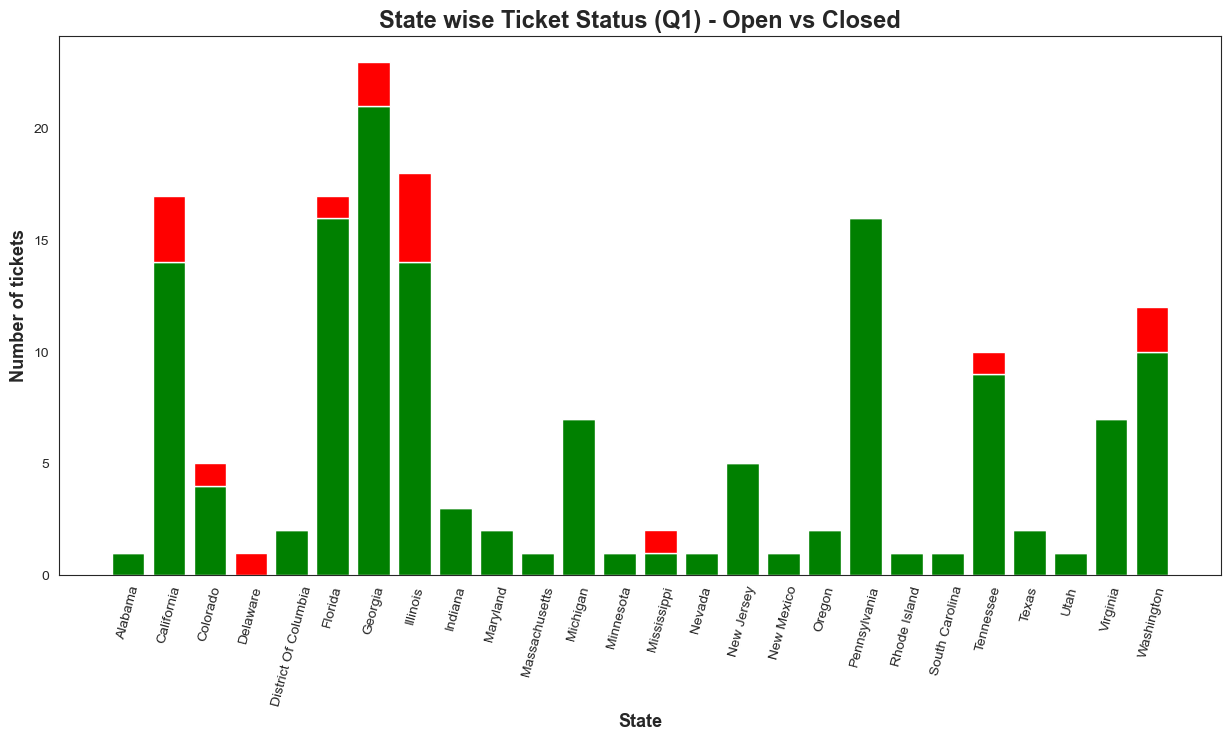

In [148]:
sns.set_style('white')
plt.figure(figsize=(15,7))

plt.bar(state_wise_ticket_status_Q1.index, 
        state_wise_ticket_status_Q1['Closed'].values, 
        color='g')
plt.bar(state_wise_ticket_status_Q1.index, 
        state_wise_ticket_status_Q1['Open'].values, 
        bottom=state_wise_ticket_status_Q1['Closed'], 
        color='r')

plt.xticks(rotation = 75)
plt.title('State wise Ticket Status (Q1) - Open vs Closed', fontsize=17, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('State', fontsize=13, fontweight="bold");

In [146]:
state_wise_ticket_status_1 = state_wise_ticket_status_Q2.iloc[:20, :]
state_wise_ticket_status_2 = state_wise_ticket_status_Q2.iloc[20:, :]

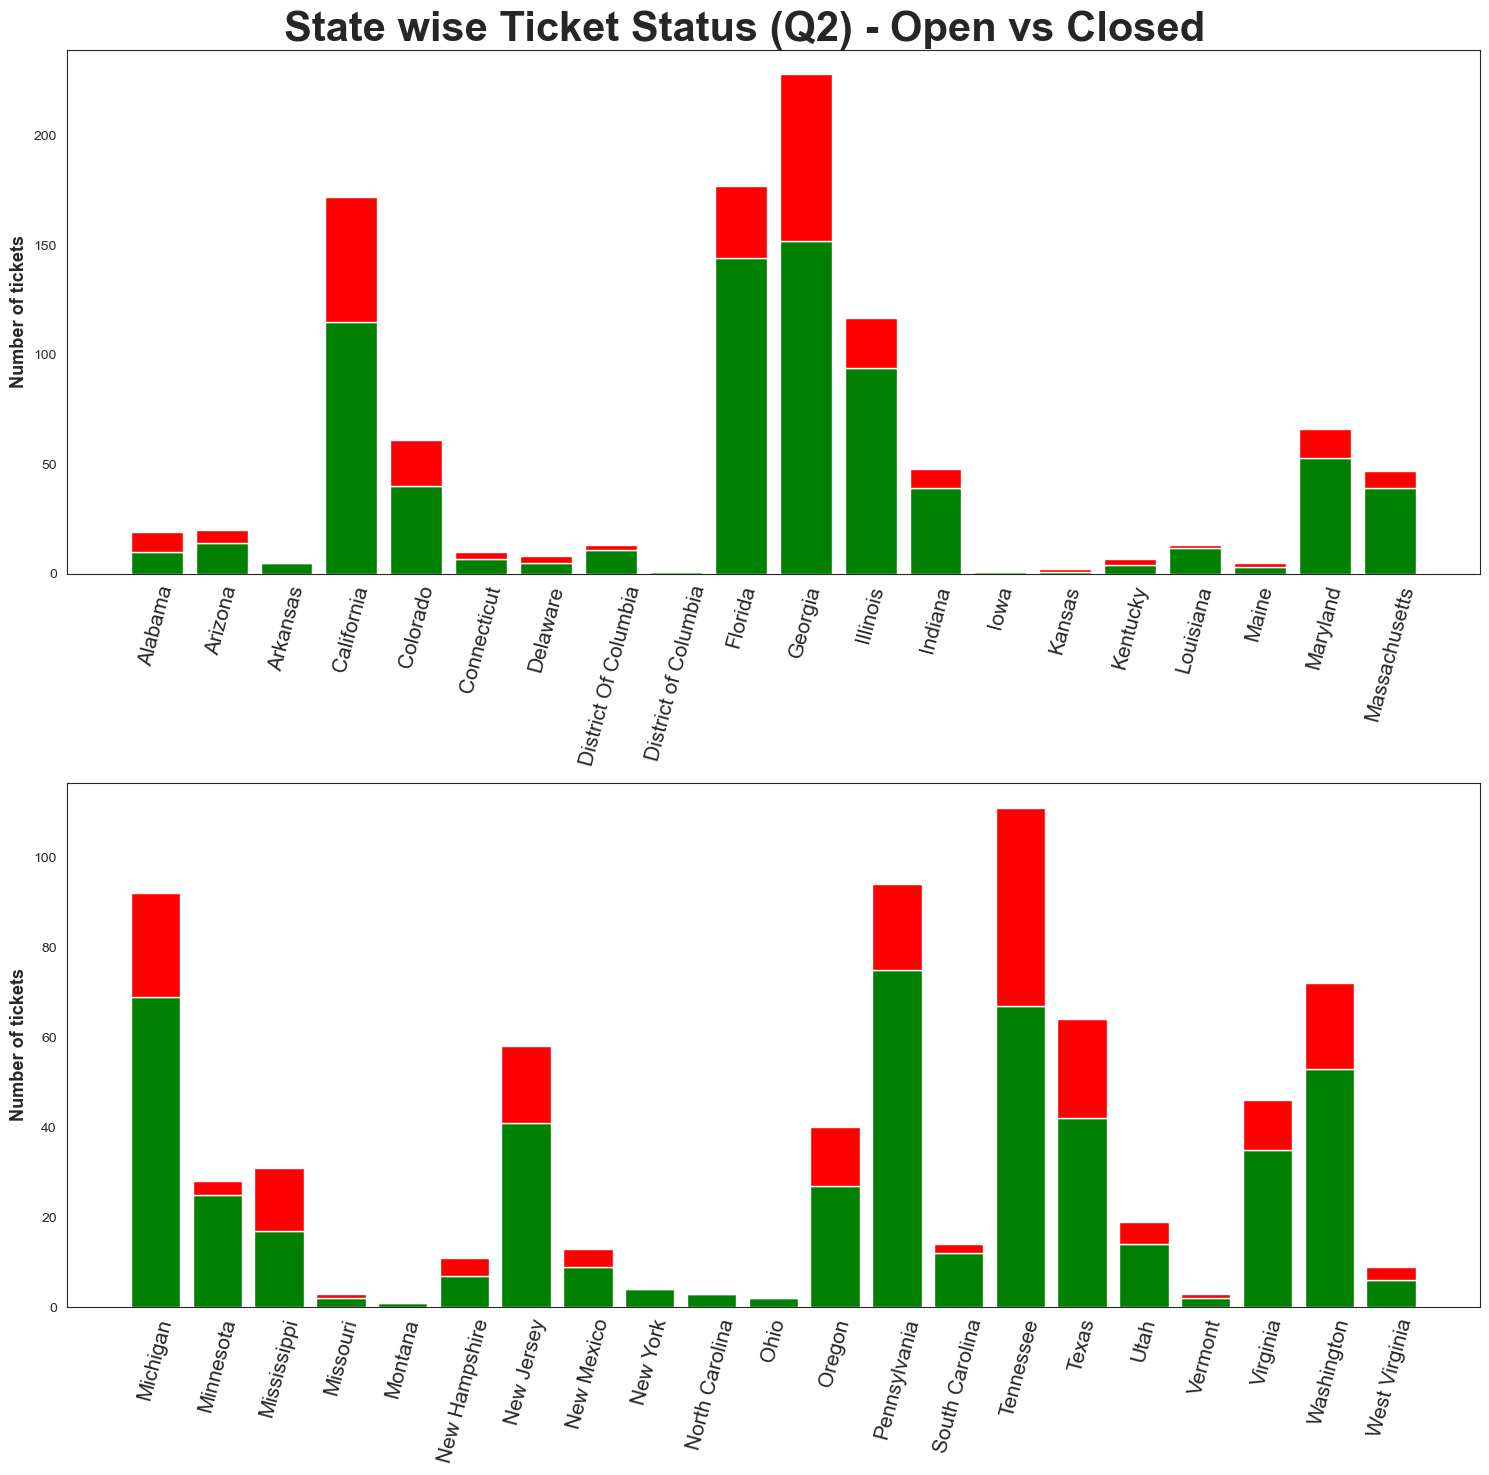

In [150]:
sns.set_style('white')
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

axs[0].bar(state_wise_ticket_status_1.index, 
        state_wise_ticket_status_1['Closed'].values, 
        color='g')
axs[0].bar(state_wise_ticket_status_1.index, 
        state_wise_ticket_status_1['Open'].values, 
        bottom=state_wise_ticket_status_1['Closed'], 
        color='r')
axs[0].set_ylabel('Number of tickets', fontsize=13, fontweight="bold")
axs[0].tick_params(axis='x', labelrotation = 75, labelsize = 15)


axs[1].bar(state_wise_ticket_status_2.index, 
        state_wise_ticket_status_2['Closed'].values, 
        color='g')
axs[1].bar(state_wise_ticket_status_2.index, 
        state_wise_ticket_status_2['Open'].values, 
        bottom=state_wise_ticket_status_2['Closed'], 
        color='r')
axs[1].set_ylabel('Number of tickets', fontsize=13, fontweight="bold")
axs[1].tick_params(axis='x', labelrotation = 75, labelsize = 15)

fig.suptitle('State wise Ticket Status (Q2) - Open vs Closed', fontsize=30, fontweight="bold")
fig.tight_layout();

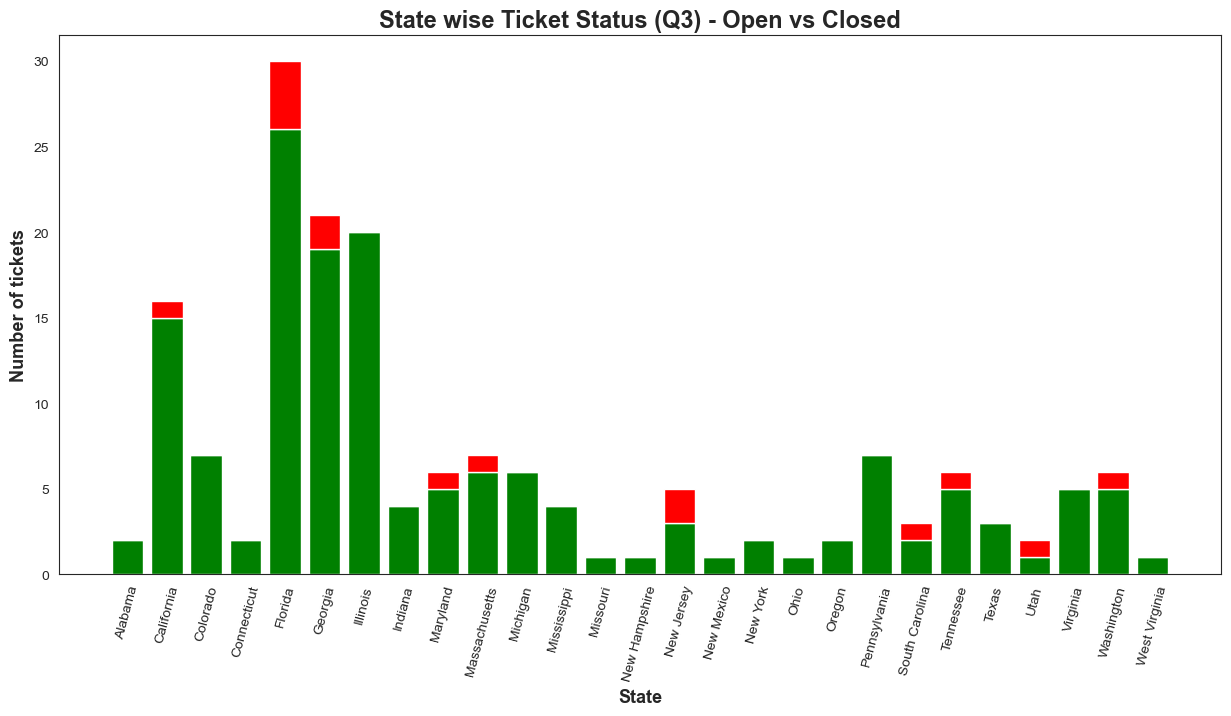

In [149]:
sns.set_style('white')
plt.figure(figsize=(15,7))

plt.bar(state_wise_ticket_status_Q3.index, 
        state_wise_ticket_status_Q3['Closed'].values, 
        color='g')
plt.bar(state_wise_ticket_status_Q3.index, 
        state_wise_ticket_status_Q3['Open'].values, 
        bottom=state_wise_ticket_status_Q3['Closed'], 
        color='r')

plt.xticks(rotation = 75)
plt.title('State wise Ticket Status (Q3) - Open vs Closed', fontsize=17, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('State', fontsize=13, fontweight="bold");

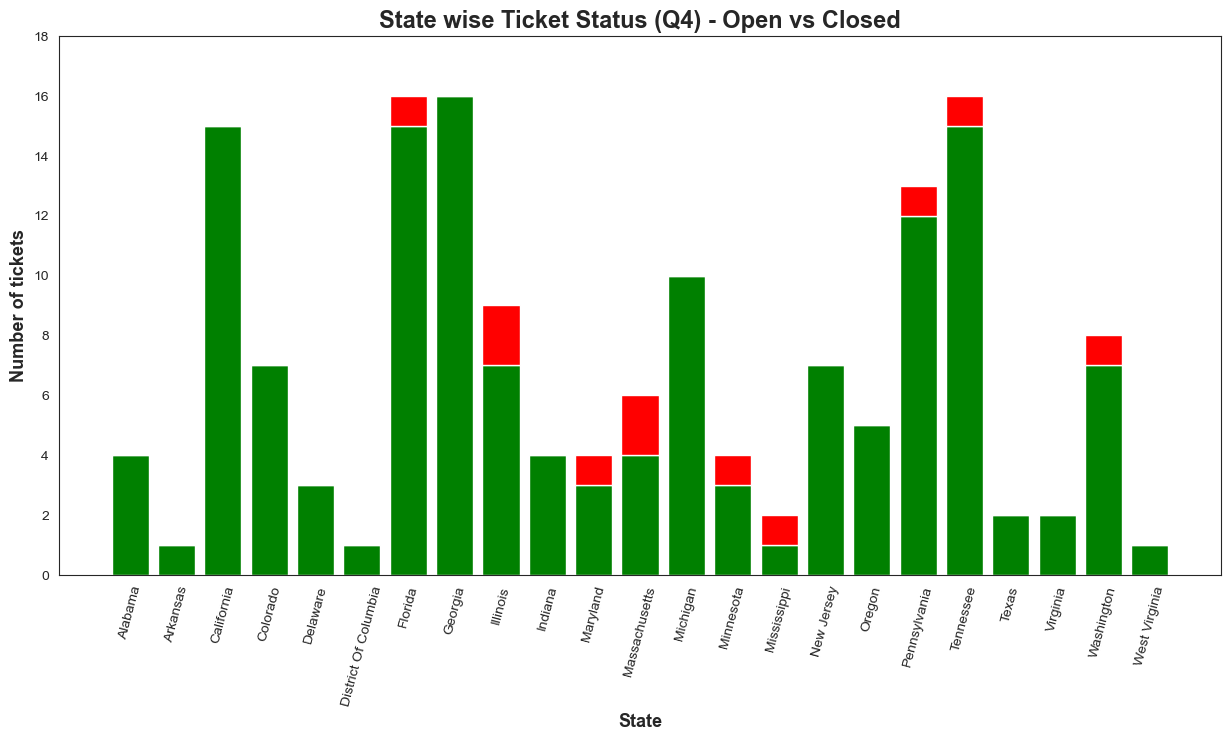

In [154]:
sns.set_style('white')
plt.figure(figsize=(15,7))

plt.bar(state_wise_ticket_status_Q4.index, 
        state_wise_ticket_status_Q4['Closed'].values, 
        color='g')
plt.bar(state_wise_ticket_status_Q4.index, 
        state_wise_ticket_status_Q4['Open'].values, 
        bottom=state_wise_ticket_status_Q4['Closed'], 
        color='r')

plt.xticks(rotation = 75)
plt.yticks(np.arange(0, 20, step=2))
plt.title('State wise Ticket Status (Q4) - Open vs Closed', fontsize=17, fontweight="bold")
plt.ylabel('Number of tickets', fontsize=13, fontweight="bold")
plt.xlabel('State', fontsize=13, fontweight="bold");

In [156]:
comcast_data.head()

,Customer Complaint,Time,Received Via,City,State,Status,Filing on Behalf of Someone,Day,Month,Month_num,Year,Quarter,Ticket_State
0,Comcast Cable Internet Speeds,3:53:50 PM,Customer Care Call,Abingdon,Maryland,Closed,No,22,April,4,2015,2,Closed
1,Payment disappear - service got disconnected,10:22:56 AM,Internet,Acworth,Georgia,Closed,No,4,August,8,2015,3,Closed
2,Speed and Service,9:55:47 AM,Internet,Acworth,Georgia,Closed,Yes,18,April,4,2015,2,Closed
3,Comcast Imposed a New Usage Cap of 300GB that ...,11:59:35 AM,Internet,Acworth,Georgia,Open,Yes,5,July,7,2015,3,Open
4,Comcast not working and no service to boot,1:25:26 PM,Internet,Acworth,Georgia,Solved,No,26,May,5,2015,2,Closed


In [157]:
comcast_data.columns

Index(['Customer Complaint', 'Time', 'Received Via', 'City', 'State', 'Status',
       'Filing on Behalf of Someone', 'Day', 'Month', 'Month_num', 'Year',
       'Quarter', 'Ticket_State'],
      dtype='object')

In [159]:
overall_ticket_statewise = comcast_data[['Customer Complaint','State','Ticket_State']].groupby(
                                                                    ['State', 'Ticket_State']).count()['Customer Complaint']
overall_ticket_statewise

State          Ticket_State
Alabama        Closed          17
               Open             9
Arizona        Closed          14
               Open             6
Arkansas       Closed           6
                               ..
Virginia       Open            11
Washington     Closed          75
               Open            23
West Virginia  Closed           8
               Open             3
Name: Customer Complaint, Length: 77, dtype: int64

In [162]:
overall_ticket_statewise = overall_ticket_statewise.unstack().reset_index(drop=False)
overall_ticket_statewise.head()

Ticket_State,State,Closed,Open
0,Alabama,17.0,9.0
1,Arizona,14.0,6.0
2,Arkansas,6.0,NaN
3,California,159.0,61.0
4,Colorado,58.0,22.0


In [169]:
overall_ticket_statewise = overall_ticket_statewise.rename_axis(None, axis=1)
overall_ticket_statewise = overall_ticket_statewise.fillna(0)
overall_ticket_statewise = overall_ticket_statewise.astype({'Closed': 'int64', 'Open': 'int64'})

In [170]:
overall_ticket_statewise.head()

,State,Closed,Open
0,Alabama,17,9
1,Arizona,14,6
2,Arkansas,6,0
3,California,159,61
4,Colorado,58,22


In [210]:
max_index = overall_ticket_statewise.iloc[:, 1:].sum(axis = 1).idxmax()
print(f"State '{overall_ticket_statewise.loc[max_index, 'State']}' has maximum number of complaints.")

State 'Georgia' has maximum number of complaints


In [211]:
overall_ticket_statewise.loc[[10],]

,State,Closed,Open
10,Georgia,208,80


In [215]:
max_unresolved_state = overall_ticket_statewise[overall_ticket_statewise['Open'] == overall_ticket_statewise['Open'].max()]
max_unresolved_state

,State,Closed,Open
10,Georgia,208,80


In [220]:
print(f"State '{max_unresolved_state['State'].values}' has maximum number of complaints.")

State '['Georgia']' has maximum number of complaints.


In [223]:
overall_ticket_statewise.loc[max_index]

State     Georgia
Closed        208
Open           80
Name: 10, dtype: object

In [228]:
top_6_states_max_unresolved = overall_ticket_statewise.sort_values(by = 'Open', ascending=False).head(6)
top_6_states_max_unresolved

,State,Closed,Open
10,Georgia,208,80
3,California,159,61
36,Tennessee,96,47
9,Florida,201,39
11,Illinois,135,29
41,Washington,75,23


In [230]:
top_6_states_max_unresolved['Open_percent'] = (round(top_6_states_max_unresolved['Open']/top_6_states_max_unresolved['Open'].sum(),2))*100

In [231]:
top_6_states_max_unresolved

,State,Closed,Open,Open_percent
10,Georgia,208,80,29.0
3,California,159,61,22.0
36,Tennessee,96,47,17.0
9,Florida,201,39,14.0
11,Illinois,135,29,10.0
41,Washington,75,23,8.0


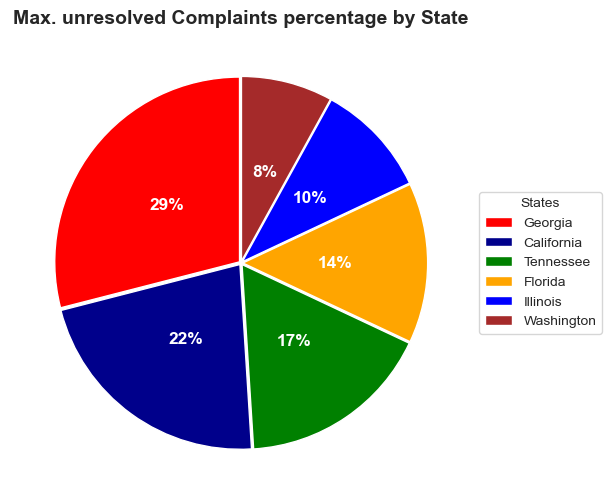

In [244]:
fig, ax = plt.subplots(figsize=[12,6])
labels = ticket_state_percent.index
wedges, texts, autopcts = ax.pie(x= top_6_states_max_unresolved['Open_percent'].values, 
                        autopct="%1.0f%%",
                        explode=[0.01]*len(top_6_states_max_unresolved), 
                        #labels=labels, 
                        pctdistance=0.5,
                        #shadow=True,
                        colors = ['Red', 'darkblue', 'Green', 'Orange', 'Blue', 'Brown'],
                        startangle = 90)
# Adding legend
ax.legend(wedges, top_6_states_max_unresolved['State'].values,
          title ="States",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.title("Max. unresolved Complaints percentage by State", fontsize=14, fontweight="bold");